In [1]:
import numpy as np

In [2]:
from key_door import key_door_env, visualisation_env
from sac import utils

In [3]:
map_path = 'square_map.txt'
map_yaml_path = 'square_map.yaml'

# map_path = 'square_map.txt'
# map_yaml_path = 'square_map.yaml'

In [4]:
episode_timeout = 1000

In [5]:
env = key_door_env.KeyDoorEnv(map_ascii_path=map_path, map_yaml_path=map_yaml_path, representation="agent_position", episode_timeout=episode_timeout)
env = visualisation_env.VisualisationEnv(env)

In [6]:
env.reset_environment(train=True)

(np.int64(2), np.int64(3), np.int64(0))

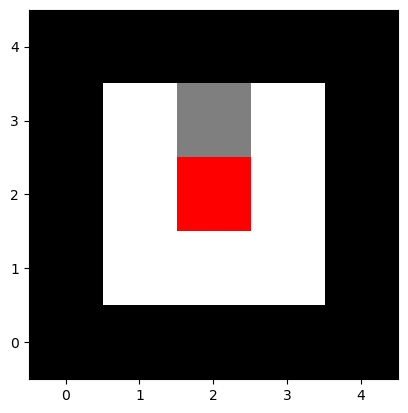

In [7]:
env.render()

In [8]:
state_id_mapping = {state: i for i, state in enumerate(env.positional_state_space)}
id_state_mapping = {i: state for i, state in enumerate(env.positional_state_space)}

In [9]:
S = len(env.positional_state_space)
A = len(env.action_space)

P = np.zeros((S, A, S))
R = np.zeros((S, A))

reward_positions = list(env._env._rewards.keys())

for state in env.positional_state_space:
    state_index = state_id_mapping[state]
    if state not in reward_positions:
        for action in env.action_space:
            # set env and transition
            env.reset_environment(train=True)
            env.move_agent_to(state)
            reward, new_state = env.step(action)
            # import pdb; pdb.set_trace()
            new_state_index = state_id_mapping[new_state[:2]]
            P[state_index][action][new_state_index] = 1
            R[state_index][action] = reward

In [10]:
state_blocks, sa_blocks, state_label, sa_label, P_tilde, R_tilde, action_index_per_block = utils.joint_state_action_abstraction(P, R)

In [11]:
state_blocks

[[0], [1], [2], [3], [4], [5], [6], [7], [8]]

In [20]:
sa_blocks

[[(0, 0), (0, 3), (1, 0), (3, 3)],
 [(0, 1), (3, 0), (6, 3)],
 [(0, 2), (1, 3), (2, 0)],
 [(1, 1)],
 [(1, 2), (2, 2), (2, 3), (5, 3)],
 [(2, 1), (5, 2), (8, 3)],
 [(3, 1), (6, 0), (6, 1), (7, 0)],
 [(3, 2)],
 [(4, 0), (4, 1), (4, 2), (4, 3)],
 [(5, 0)],
 [(5, 1), (7, 2), (8, 1), (8, 2)],
 [(6, 2), (7, 1), (8, 0)],
 [(7, 3)]]

In [21]:
action_index_per_block

[{np.int64(0): 0, np.int64(1): 1, np.int64(2): 2},
 {np.int64(0): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3},
 {np.int64(2): 0, np.int64(4): 1, np.int64(5): 2},
 {np.int64(0): 0, np.int64(1): 1, np.int64(6): 2, np.int64(7): 3},
 {np.int64(8): 0},
 {np.int64(4): 0, np.int64(5): 1, np.int64(9): 2, np.int64(10): 3},
 {np.int64(1): 0, np.int64(6): 1, np.int64(11): 2},
 {np.int64(6): 0, np.int64(10): 1, np.int64(11): 2, np.int64(12): 3},
 {np.int64(5): 0, np.int64(10): 1, np.int64(11): 2}]

In [13]:
state_label

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [14]:
sa_label

array([[ 0,  1,  2,  0],
       [ 0,  3,  4,  2],
       [ 2,  5,  4,  4],
       [ 1,  6,  7,  0],
       [ 8,  8,  8,  8],
       [ 9, 10,  5,  4],
       [ 6,  6, 11,  1],
       [ 6, 11, 10, 12],
       [11, 10, 10,  5]])

In [37]:
blocks, label = utils.deterministic_bisimulation(P, R)

In [38]:
len(blocks)

47

In [28]:
label

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

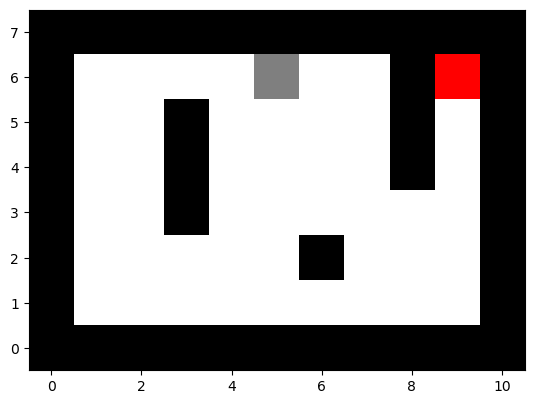

In [25]:
env.render()

In [11]:
env.move_agent_to(env.state_space[0][:2])

In [19]:
env.get_state_representation()[0][0]

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ],
       [0.   , 0.5  , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 0.   ],
       [0.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.   , 1.   , 1.   ,
        1.   , 0.   ],
       [0.   , 1.   , 1.   , 0.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 0.   ],
       [0.   , 1.   , 1.   , 0.   , 1.   , 1.   , 1.   , 1.   , 0.   ,
        1.   , 0.   ],
       [0.   , 1.   , 1.   , 0.   , 1.   , 1.   , 1.   , 1.   , 0.   ,
        1.   , 0.   ],
       [0.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.   ,
        0.299, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]])

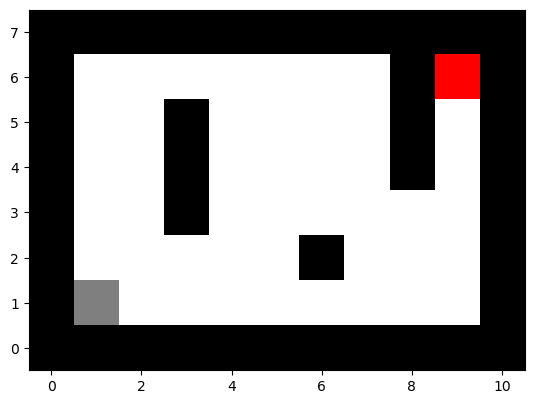

In [12]:
env.render()

In [21]:
import matplotlib.pyplot as plt

In [24]:
env.get_state_representation().shape

(1, 1, 8, 11)

In [30]:
env.state_space[:10]

[(np.int64(1), np.int64(1), 0),
 (np.int64(1), np.int64(1), 1),
 (np.int64(2), np.int64(1), 0),
 (np.int64(2), np.int64(1), 1),
 (np.int64(3), np.int64(1), 0),
 (np.int64(3), np.int64(1), 1),
 (np.int64(4), np.int64(1), 0),
 (np.int64(4), np.int64(1), 1),
 (np.int64(5), np.int64(1), 0),
 (np.int64(5), np.int64(1), 1)]

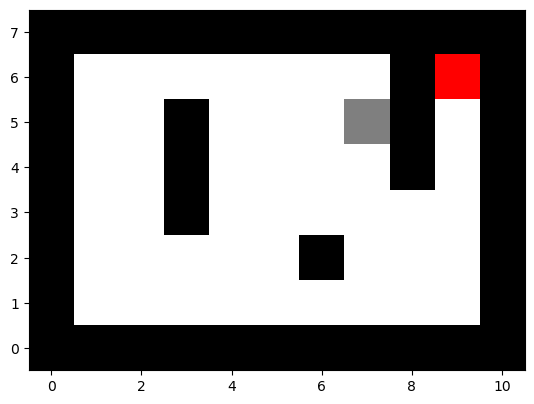

In [28]:
env.render()

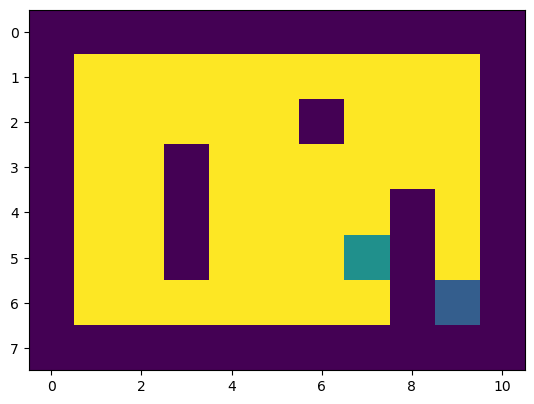

In [26]:
plt.imshow(env.get_state_representation(tuple_state=env.state_space[0])[0][0])